# MNIST Handwritten Digit Recognition using VAE

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Running TF without GPU')
else:
    print(f'Found GPU at {device_name}')

Running TF without GPU


In [2]:
%matplotlib inline

import glob
import imageio
import math
import os
import seaborn as sn

from abc import abstractstaticmethod
from matplotlib import gridspec
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow import keras

sn.set_theme()

In [3]:
TRAIN_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 200

N_EXAMPLES = 25
LEARNING_RATE = 1e-4
LATENT_DIMENSION = 3

ARCH = 'vae'
METRICS_PATH = f'metrics/{ARCH}/'
OUTPUT_PATH = f'output/{ARCH}/'

!mkdir -p $METRICS_PATH
!mkdir -p $OUTPUT_PATH

## Base Class

In [4]:
class BaseNetwork(tf.Module):
    def __init__(self):
        super().__init__()

    @tf.Module.with_name_scope
    def __call__(self, input_data, training=False) -> tf.Tensor:
        output_data = input_data
        for layer in self.layers:
            output_data = layer(output_data, training=training)
        return output_data

## Encoder Network
### Layers
<pre>
<b>Input</b>:  input_size=(28, 28, 1), target_shape=(784, 1)
<b>Dense</b>:  units=256, activation=tanh
<b>Dense</b>:  units=2*2, target_shape=(3, 2)
</pre>
### Output
The output layer of the encoder network represents the mean (&mu;) and log-variance (log &sigma;<sup>2</sup>) of the posterior distribution which the decoder should sample from. The output looks as follows:
<pre>
         [ &mu;<sub>1</sub> &sigma;<sub>1</sub> ]
e(x)  ~  [ &mu;<sub>2</sub> &sigma;<sub>2</sub> ]
         [ &mu;<sub>3</sub> &sigma;<sub>3</sub> ]
</pre>
Using the reparameterization trick, the input to the decoder network becomes:
<center><i><b>z</b></i> = &mu; + &sigma; &xodot; &epsilon;</center>
where &epsilon; ~ <i>N</i>(0,<i>I</i>). We use log &sigma;<sup>2</sup> here since the parameters the network outputs does not have a bound just as log &sigma;<sup>2</sup> has no bound on its range, i.e the output does not have any non-linearity which would normally restrict the range of the output values, as to not completely restrict the latent distribution which the values parameterize.

In [5]:
class Encoder(BaseNetwork):
    def __init__(self, input_shape: tuple, latent_dimension: int) -> None:
        super().__init__()
        self.latent_dimension = latent_dimension
        self.layers = [
            keras.layers.InputLayer(input_shape=input_shape),
            keras.layers.Flatten(),
            keras.layers.Dense(units=256),
            keras.layers.Activation(tf.nn.tanh),
            keras.layers.Dense(units=latent_dimension*2),
            keras.layers.Reshape(target_shape=(latent_dimension, 2))
        ]
    
    @tf.Module.with_name_scope
    def __call__(self, input_data, training=False) -> tf.Tensor:
        output_data = input_data
        for layer in self.layers:
            output_data = layer(output_data, training=training)
        mean, log_var = output_data[:, :, 0], output_data[:, :, 1]
        epsilon = tf.random.normal(shape=log_var.shape)
        # sd = e^(log(var^.5)) = e^(0.5*log(var))
        stddev = tf.math.multiply(epsilon, tf.math.exp(0.5 * log_var))
        # Reparameterization: z ~ N(mean, stddev * epsilon)
        return mean + stddev*epsilon, mean, tf.math.exp(log_var)

## Decoder Network
### Layers
<pre>
<b>Input</b>:   input_size=(2,)
<b>Dense</b>:   units=256, activation=tanh
<b>Dense</b>:   units=784, activation=sigmoid, target_shape=(28, 28)
</pre>

### Optimizer
<pre>
<b>Adagrad</b>: learning_rate=0.0001
</pre>

### Loss
<pre>
<b>&Lscr;</b>(<i>&theta;</i>,<i>&phi;</i>) = -<i>D<sub>KL</sub></i>(<i>q<sub>&phi;</sub></i>(<i><b>z</b></i>) &vert;&vert; <i>p<sub>&theta;</sub></i>(<i><b>z</b></i>)) + &Eopf;<sub><i>q<sub>&phi;</sub></i>(<i><b>z</b></i>&vert;<i><b>x</b></i>)</sub>log <i>p<sub>&theta;</sub></i>(<i><b>x</b></i>&vert;<i><b>z</b></i>)
        &approx; &frac12; &Sum;<sub>j</sub> [1 + log(<i>&sigma;<sub>j</sub><sup>2</sup></i>) - <i>&mu;<sub>j</sub><sup>2</sup></i> - <i>&sigma;<sub>j</sub><sup>2</sup></i>] + &Eopf;<sub><i>q<sub>&phi;</sub></i>(<i><b>z</b></i>&vert;<i><b>x</b></i>)</sub>log <i>p<sub>&theta;</sub></i>(<i><b>x</b></i>&vert;<i><b>z</b></i>)
        &approx; &frac12; &Sum;<sub>j</sub> [1 + log(<i>&sigma;<sub>j</sub><sup>2</sup></i>) - <i>&mu;<sub>j</sub><sup>2</sup></i> - <i>&sigma;<sub>j</sub><sup>2</sup></i>] +  &Sum;<sub>i</sub> [<i>x<sub>i</sub></i>log(<i>y<sub>i</sub></i>) + (1 - <i>x<sub>i</sub></i>)&lowast;log(1 - <i>y<sub>i</sub></i>)]
</pre>

### Goal
Find argmin<sub><i>&theta;</i>,<i>&phi;</i></sub> <b>&Lscr;</b>(<i>&theta;</i>,<i>&phi;</i>), and use <i>p<sub>&theta;</sub></i>(<i><b>x</b></i>&vert;<i><b>z</b></i>) as a generator

In [6]:
class Decoder(BaseNetwork):
    def __init__(self, latent_dimension: int, output_shape: tuple) -> None:
        super().__init__()
        self.latent_dimension = latent_dimension
        self.layers = [
            keras.layers.InputLayer(input_shape=(latent_dimension,)),
            keras.layers.Dense(units=256),
            keras.layers.Activation(tf.nn.tanh),
            keras.layers.Dense(units=tf.math.reduce_prod(output_shape)),
            keras.layers.Activation(tf.nn.sigmoid),
            keras.layers.Reshape(target_shape=output_shape),
        ]

## Preprocessing
* Import MNIST images
* Normalize to \[0, 1\]
* Collapse pixels to 0/1 for sharper image features
* Shuffle and batch dataset

In [7]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
train_images = train_images[:TRAIN_SIZE] / 255.
train_images = tf.round(train_images)
train_images = tf.dtypes.cast(train_images, tf.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
                               .shuffle(TRAIN_SIZE) \
                               .batch(BATCH_SIZE)
image_shape = train_images.shape[1:]

test_images = test_images[:N_EXAMPLES] / 255.
test_images = tf.round(test_images)
test_images = tf.dtypes.cast(test_images, tf.float32)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images) \
                              .shuffle(TRAIN_SIZE) \
                              .batch(BATCH_SIZE)

### Initialize Encoder and Decoder

In [8]:
encoder = Encoder(image_shape, LATENT_DIMENSION)
decoder = Decoder(LATENT_DIMENSION, image_shape)

### Define metrics to record through training

In [9]:
sample_encoded_tests = test_images[:N_EXAMPLES, :, :]
metric_names = ['kl_loss', 'rec_loss', 'loss']
batch_history = { name: [] for name in metric_names }

### Capture training visualization

In [10]:
def record_sample(encoder: Encoder, decoder: Decoder, epoch: int, save: bool=True, show: bool=True):
    encoded_input, _, _ = encoder(sample_encoded_tests)
    sampled_input = tf.random.normal(encoded_input.shape)

    encoder_decoder = decoder(encoded_input)
    sampled_decoder = decoder(sampled_input)

    f = plt.figure(figsize=(12, 4))
    f.suptitle('VAE Output')
    outer = gridspec.GridSpec(1, 3)
    titles = ['Ground Truth', 'Encoder Latent Distribution', 'Standard Normal Distribution']
    data = [sample_encoded_tests, encoder_decoder, sampled_decoder]
    for i in range(3):
        inner = gridspec.GridSpecFromSubplotSpec(int(math.sqrt(N_EXAMPLES)), int(math.sqrt(N_EXAMPLES)), subplot_spec=outer[i])
        predictions = data[i]
        for j in range(predictions.shape[0]):
            ax = plt.Subplot(f, inner[j])
            ax.imshow(predictions[j] * 255, cmap=plt.cm.gray)
            ax.axis('off')
            if j == int(math.sqrt(N_EXAMPLES)) // 2:
                ax.set_title(titles[i])
            f.add_subplot(ax)

    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()
    plt.close()

## VAE Algorithm
<pre>
<i>&theta;</i>,<i>&phi;</i> &leftarrow; Initialize parameters
<b>repeat</b>
    <i>X<sup>M</sup></i>  &leftarrow; Random minibatch of <i>M</i> datapoints (drawn from full dataset)
    <i>&epsilon;</i>   &leftarrow; Random samples from noise distribution <i>p</i>(<i>&epsilon;</i>)
    <i>g</i>   &leftarrow; &Del;<sub><i>&theta;</i>,<i>&phi;</i></sub>&Lscr;<sup>M</sup>(<i>&theta;</i>,<i>&phi;</i>; <i>X<sup>M</sup></i>,<i>&epsilon;</i>) (Gradients of minibatch estimator)
    <i>&theta;</i>,<i>&phi;</i> &leftarrow; Update parameters using gradients <i><b>g</b></i> (e.g. SGD or Adagrad)
<b>until</b> convergence of parameters (<i>&theta;</i>,<i>&phi;</i>)
<b>return</b> <i>&theta;</i>,<i>&phi;</i>
</pre>

Source: https://arxiv.org/pdf/1312.6114.pdf

In [11]:
record_sample(encoder, decoder, 0, show=False)
optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
epsilon = 1e-8

for epoch in range(1, EPOCHS+1):
    print(f'\nepoch {epoch}/{EPOCHS}')
    progress_bar = keras.utils.Progbar(TRAIN_SIZE / BATCH_SIZE, stateful_metrics=metric_names)

    for i, image_batch in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            posterior_sample, mean, var = encoder(image_batch, training=True)

            reconstructed_image_batch = decoder(posterior_sample,training=True)

            analytic_kl_divergence = 0.5 * tf.reduce_sum(
                1 + tf.math.log(var+epsilon) - tf.math.square(mean) - var,
                axis=1,
            )
            log_likelihood = tf.reduce_sum(
                tf.math.add(
                    tf.math.multiply(image_batch, tf.math.log(reconstructed_image_batch+epsilon)),
                    tf.math.multiply((1-image_batch), tf.math.log(1-reconstructed_image_batch+epsilon)),
                ),
                axis=[1,2],
            )
            kl_loss = -tf.reduce_mean(analytic_kl_divergence)
            rec_loss = -tf.reduce_mean(log_likelihood)
            loss = kl_loss + rec_loss

        training_metrics = {
            'kl_loss': kl_loss,
            'rec_loss': rec_loss,
            'loss': loss,
        }

        # Record loss history
        for metric in batch_history:
            batch_history[metric].append(training_metrics[metric])

        metric_values = training_metrics.items()
        progress_bar.update(i, values=metric_values)

        model_vars = [*encoder.trainable_variables, *decoder.trainable_variables]
        grad = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(zip(grad, model_vars))

    progress_bar.update(TRAIN_SIZE / BATCH_SIZE, values=metric_values, finalize=True)
    record_sample(encoder, decoder, epoch, show=False)


epoch 1/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 9.2077 - rec_loss: 215.0445 - loss: 224.2522: 5s - kl_loss: 16.8154 - rec_loss: 229.7883 - loss: 246.6 - ETA: 5s - kl_loss: 16 - ETA: 2s - kl_loss: 11.5726 - rec_loss: 211.2276 - loss - ETA: 1s - kl_loss: 10.5549 - rec_l

epoch 2/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 8.6111 - rec_loss: 183.0061 - loss: 191.61732s - kl_loss: 9.2917 - rec_loss: 185.3106 - loss: 19 - ETA: 1s - kl_loss: 9.6283 - rec_loss: 186.2263 - loss: 195.85 - ETA: 1s - kl_loss: 10.0666 - rec_loss: 183.4019 - loss: 1 - ETA: 1s - kl_lo

epoch 3/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 8.0336 - rec_loss: 176.6944 - loss: 184.72803s - kl_loss: 7.9687 - rec_loss: 1 - ETA: 0s - kl_loss: 7.5607 - rec_loss: 176.0684 - loss: 183. - ETA: 0s - kl_loss: 7.4889 - rec_loss: 177.7685 - loss: 185.

epoch 4/200
468/468 [==============================] - 11s 22ms/step - kl_loss: 6.9060 - rec_

468/468 [==============================] - 11s 23ms/step - kl_loss: 8.0201 - rec_loss: 139.6981 - loss: 147.71810s - kl_loss: 7.9942 - rec_loss: 142.8997 - loss: 150.89

epoch 40/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 7.7643 - rec_loss: 144.3845 - loss: 152.1487

epoch 41/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 7.8678 - rec_loss: 147.9587 - loss: 155.82655s - kl_loss: 7.9404 - rec_loss: 138.1970 - loss:  - ETA: 4s - kl_loss: 7.5883 - rec_loss: - ETA: 3s - kl_loss: 8.3867 - r - ETA: 2s - kl_loss: 7.6586 - rec_loss: 139.9571 - loss:  - ETA: 2s - kl_loss: 8.0180 - rec_loss: 149 - ETA: 1s - kl_loss: 8. - ETA: 0s - kl_loss: 8.0950 - rec_loss: 146.8498 - lo

epoch 42/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 7.8972 - rec_loss: 133.8713 - loss: 141.76846s - kl_loss: 7.9860 - rec - ETA: 5s - kl_loss: 7.9867 - rec_los - ETA: 4s - ETA: 2s - kl_loss: 7.9331 - rec_loss: 136.268 - ETA: 2s - kl_loss: 8.012

468/468 [==============================] - 11s 23ms/step - kl_loss: 8.5091 - rec_loss: 134.9781 - loss: 143.4871: 10s - kl_los - ETA: 3s - kl_loss: 8.48

epoch 73/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 8.7103 - rec_loss: 132.5132 - loss: 141.22342s - kl_loss: 8.5702 - rec_loss: 134

epoch 74/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 8.7683 - rec_loss: 124.9174 - loss: 133.68574s - kl_loss: 8.7626 - rec - ETA: 3s - kl_loss: 8.5976 - rec_loss: 132.9443 - loss - ETA: 3s - ETA: 1s - kl_loss: 8.3455 - rec - ETA: 0s - kl_loss: 8.3075 - rec_loss: 127.0933 - loss: 13

epoch 75/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 8.3365 - rec_loss: 129.5722 - loss: 137.90874s - kl_loss: 8.4177 - rec_loss: 133.8829 - lo - ETA: 4s - kl_loss: 8.5731 - rec_loss: 131.7374 - loss: 14 - E

epoch 76/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 8.2298 - rec_loss: 130.2292 - loss: 138.45895s - kl_

468/468 [==============================] - 11s 22ms/step - kl_loss: 8.7079 - rec_loss: 126.7842 - loss: 135.4921

epoch 111/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 8.8580 - rec_loss: 122.9019 - loss: 131.75981s - kl_loss: 8.7521 - rec_loss: 122.3336  - ETA: 1s - kl_loss: 8.7586 - rec_loss: 129.2570 - loss: 13 - ETA: 1s - kl_loss: 8.5593 - rec_loss: 124.1399 - loss: 132.69 - ETA: 1s - kl_loss: 8.8276 - rec_loss: 130.0939  - ETA: 0s - kl_loss: 8.6451 - rec_loss: 128.1

epoch 112/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 8.9682 - rec_loss: 126.4523 - loss: 135.42055s - kl_loss: 8.6048 - rec

epoch 113/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 8.5610 - rec_loss: 127.1997 - loss: 135.76074s - kl_loss: 8.7846 - rec_loss: 129.4912 -  - ETA: 1s - kl_loss: 8.6440 - rec_loss: 118.7648  - ETA: 1s - kl_loss: 8.83

epoch 114/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 8.9608 - rec

468/468 [==============================] - 11s 23ms/step - kl_loss: 9.1565 - rec_loss: 125.5366 - loss: 134.69324s - kl_loss:  - ETA: 3s - kl_loss: 8.9787 - rec_loss: 122.9886 - loss: 131. - ETA: 3s - kl_loss: 8.8757 - rec_loss: 126.534 - ETA: 2s - kl_loss: 8.8128 - rec_loss: 128.8102 - lo - ETA: 2s - kl_loss: 8.7713 - rec_loss: 119.2341 -  - ETA: 1s - kl_loss: 9.0181 - rec_loss: 120.1720 - lo - ETA: 1s - kl_loss: 8.8431 - rec_loss: 1 - ETA: 0s - kl_loss: 8.9293 - rec_loss: 120.5306 - lo

epoch 144/200
468/468 [==============================] - 11s 22ms/step - kl_loss: 9.1053 - rec_loss: 132.2820 - loss: 141.38736s - kl_loss: 9.0283 - rec_loss: 126.6266 - loss: 135.65 - ETA: 5s - kl_loss: 9.1361 - - ETA: 2s - kl_loss: 8.8071 - rec_loss: 122.3 - ETA

epoch 145/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 9.0369 - rec_loss: 121.4559 - loss: 130.49281s - kl_loss: 9.0540 - rec_loss: 119.1346 - loss: 128.18 - ETA: 1s - kl_loss: 8.8975 - r

epoch 146/200
468/468 [=

468/468 [==============================] - 11s 22ms/step - kl_loss: 8.9616 - rec_loss: 114.4177 - loss: 123.37930s - kl_loss: 9.2333 - rec_loss: 119.0936 - lo

epoch 180/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 9.0095 - rec_loss: 115.8767 - loss: 124.88624s - kl_loss: 9.2796 - ETA: 3s - kl_loss

epoch 181/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 9.0659 - rec_loss: 119.6644 - loss: 128.7303

epoch 182/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 8.9996 - rec_loss: 121.6494 - loss: 130.6490

epoch 183/200
468/468 [==============================] - 10s 22ms/step - kl_loss: 9.1352 - rec_loss: 118.6291 - loss: 127.76447s - kl_loss: 9.0835 - rec_loss: 123.7017 - loss:  - E - ETA: 4s - kl_loss: 9.1921 - rec_loss: - ETA: 3s -

epoch 184/200
468/468 [==============================] - 11s 23ms/step - kl_loss: 8.8475 - rec_loss: 118.9747 - loss: 127.82222s - kl_loss: 9.0530 - rec_loss: 124.1

epoch 185/200
46

### Loss Plots

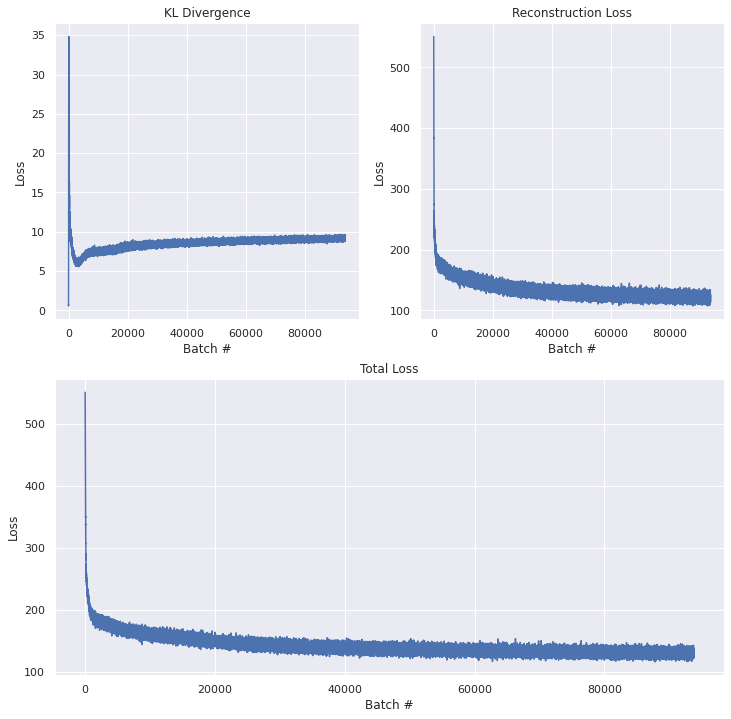

In [15]:
gs = gridspec.GridSpec(2, 2)
plt.figure(figsize=(12, 12))

batch_label = 'Batch #'
loss_label = 'Loss'

ax = plt.subplot(gs[0, 0])
plt.title('KL Divergence')
plt.xlabel(batch_label)
plt.ylabel(loss_label)
plt.plot(batch_history['kl_loss'])

ax = plt.subplot(gs[0, 1])
plt.title('Reconstruction Loss')
plt.xlabel(batch_label)
plt.ylabel(loss_label)
plt.plot(batch_history['rec_loss'], label='VAE Loss')

ax = plt.subplot(gs[1, :])
plt.title('Total Loss')
plt.xlabel(batch_label)
plt.ylabel(loss_label)
plt.plot(batch_history['loss'], label='VAE Loss')

plt.savefig(os.path.join(METRICS_PATH, 'loss.png'))
plt.show()
plt.close()

### Final Result

In [14]:
with imageio.get_writer(os.path.join(METRICS_PATH, 'vae.gif'), mode='I') as writer:
    filenames = glob.glob(os.path.join(OUTPUT_PATH, 'epoch*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
final = Image.open(os.path.join(OUTPUT_PATH, 'epoch_{:04d}.png'.format(epoch)))
final.save(os.path.join(METRICS_PATH, 'epoch_{:04d}.png'.format(epoch)))